# 06 Relationships between customer behaviors

In [1]:
import json
import sqlalchemy
import numpy as np
import pandas as pd

from pprint import pprint

In [2]:
# Make a sql connection with sqlalchmey
conn_string = "postgresql://postgres-db/churn?user=postgres&password=password" 
engine = sqlalchemy.create_engine(
    conn_string, connect_args={'options': '-csearch_path={}'.format("socialnet7,public")}
)
conn = engine.connect()
# conn.close()

# Query with Pandas, e.g. list all tables
tables = pd.read_sql_query("SELECT * FROM information_schema.tables;", conn)
tables.head(3)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,churn,socialnet7,active_period,BASE TABLE,None,None,None,None,None,YES,NO,None
1,churn,socialnet7,event_type,BASE TABLE,None,None,None,None,None,YES,NO,None
2,churn,socialnet7,metric_name,BASE TABLE,None,None,None,None,None,YES,NO,None


In [3]:
with open("/app/fightchurn/listings/conf/socialnet7_listings.json", "r") as f: 
    conf = json.loads(f.read())

chap4 = conf["chap4"]
chap6 = conf["chap6"]

## Dependent Data

- Observations as "Churn Data"
- Scored Observations AS "Scored Data"
- Listing 4.5, Listing 5.2 & Listing 5.3

### Observations

In [4]:
metric_interval = chap4["list6"]["params"]["%metric_interval"]
from_yyyy_mm_dd = chap4["defaults"]["%from_yyyy-mm-dd"]
to_yyyy_mm_dd = chap4["defaults"]["%to_yyyy-mm-dd"]

metric_interval, from_yyyy_mm_dd, to_yyyy_mm_dd

('7 day', '2020-02-09', '2020-05-10')

In [5]:
query = f"""\

WITH observation_params AS (
    SELECT  
        interval '{metric_interval}' AS metric_period,
        '{from_yyyy_mm_dd}'::timestamp AS obs_start,
        '{to_yyyy_mm_dd}'::timestamp AS obs_end
)

    SELECT 
        metric.account_id, 
        obs.observation_date, 
        obs.is_churn,
        SUM(CASE WHEN metric_name_id=0 THEN metric_value ELSE 0 END) AS like_per_month,
        SUM(CASE WHEN metric_name_id=1 THEN metric_value ELSE 0 END) AS newfriend_per_month,
        SUM(CASE WHEN metric_name_id=2 THEN metric_value ELSE 0 END) AS post_per_month,
        SUM(CASE WHEN metric_name_id=3 THEN metric_value ELSE 0 END) AS adview_per_month,
        SUM(CASE WHEN metric_name_id=4 THEN metric_value ELSE 0 END) AS dislike_per_month,
        SUM(CASE WHEN metric_name_id=5 THEN metric_value ELSE 0 END) AS unfriend_per_month,
        SUM(CASE WHEN metric_name_id=6 THEN metric_value ELSE 0 END) AS message_per_month,
        SUM(CASE WHEN metric_name_id=7 THEN metric_value ELSE 0 END) AS reply_per_month,
        SUM(CASE WHEN metric_name_id=8 THEN metric_value ELSE 0 END) AS account_tenure
      FROM metric
INNER JOIN observation_params AS params
        ON metric_time BETWEEN params.obs_start AND params.obs_end    
INNER JOIN observation AS obs
        ON metric.account_id = obs.account_id
       AND metric.metric_time > (obs.observation_date - params.metric_period)::timestamp    
       AND metric.metric_time <= obs.observation_date::timestamp
  GROUP BY metric.account_id, metric.metric_time, obs.observation_date, obs.is_churn    
  ORDER BY obs.observation_date, metric.account_id

"""
res = pd.read_sql_query(query, conn).sort_values(["account_id", "observation_date"])
res.head(6)

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
4112,1,2020-02-23,False,2.0,0.0,6.0,1.0,3.0,1.0,6.0,6.0,26.0
14104,1,2020-03-23,False,2.0,1.0,6.0,2.0,2.0,2.0,7.0,4.0,54.0
24621,1,2020-04-23,False,1.0,1.0,2.0,4.0,4.0,1.0,7.0,3.0,82.0
9178,2,2020-03-08,True,67.0,7.0,49.0,124.0,120.0,0.0,0.0,0.0,55.0
4398,4,2020-02-24,False,36.0,4.0,27.0,36.0,5.0,1.0,32.0,8.0,25.0
14425,4,2020-03-24,False,37.0,8.0,39.0,40.0,9.0,0.0,39.0,3.0,53.0


In [6]:
churn_data = res.reset_index(drop=True).copy()
churn_data.shape

(31333, 12)

### Scored Churn Data
- Summary stats
- Then scored the data

In [7]:
tmp = churn_data.drop(columns=["account_id", "is_churn"])

quantiles = {"1%": tmp.quantile(q=0.01), "99%": tmp.quantile(q=0.99)}
summary = (
    tmp.describe().transpose()
    .assign(
        skew=tmp.skew(),
        nonzero=tmp.astype(bool).sum(axis=0) / tmp.shape[0],
        **quantiles
    )[['count','nonzero','mean','std','skew','min','1%','25%','50%','75%','99%','max']]
    .rename(columns=lambda s: s.replace("%", "pct"))
)
summary

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,102.809849,206.346920,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,43.499697,79.422463,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,41.348482,71.079170,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,15.339450,21.976779,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0
unfriend_per_month,31333.0,0.255801,0.293588,0.539168,1.832746,0.0,0.0,0.0,0.0,1.0,2.00,5.0
message_per_month,31333.0,0.962946,30.144321,67.060479,8.111159,0.0,0.0,5.0,12.0,28.0,304.68,1511.0
reply_per_month,31333.0,0.789264,7.964606,22.057363,9.263953,0.0,0.0,1.0,2.0,6.0,98.00,579.0
account_tenure,31333.0,1.000000,61.068777,29.593665,0.241582,18.0,19.0,26.0,54.0,83.0,116.00,116.0


In [8]:
skew_thresh = 4.0
skewed_columns = summary[(summary['skew'] > skew_thresh) & (summary['min'] >= 0)]

In [9]:
scored_metrics = churn_data.copy()\
    .drop(columns=["account_id", "is_churn", "observation_date"])

# iterate the skewed columns
for col in skewed_columns.index:
    # add the columns log scaled
    scored_metrics[col] = np.log(1.0 + scored_metrics[col])
    
    # update summary stats with mean and std from log scaled data
    # subtract the mean and divide by std
    summary.loc[col, 'mean'] = scored_metrics[col].mean()
    summary.loc[col, 'std'] = scored_metrics[col].std()

summary.head()

,count,nonzero,mean,std,skew,min,1pct,25pct,50pct,75pct,99pct,max
like_per_month,31333.0,0.993425,3.797733,1.309756,8.290009,0.0,1.0,18.0,44.0,106.0,916.68,5653.0
newfriend_per_month,31333.0,0.912871,7.194460,8.667298,3.787812,0.0,0.0,2.0,5.0,9.0,41.00,162.0
post_per_month,31333.0,0.985255,3.089984,1.196448,9.723007,0.0,0.0,9.0,21.0,48.0,329.68,2384.0
adview_per_month,31333.0,0.978266,3.021980,1.218843,6.147157,0.0,0.0,8.0,20.0,45.0,336.00,1457.0
dislike_per_month,31333.0,0.949542,2.241344,1.063766,4.841534,0.0,0.0,4.0,9.0,18.0,111.00,405.0


In [10]:
scored = (
    ((scored_metrics - summary['mean']) / summary['std'])
    .assign(
        account_id=churn_data.account_id,
        is_churn=churn_data.is_churn,
        observation_date=churn_data.observation_date
    )[["account_id", "observation_date", "is_churn", *scored_metrics.columns]]
)
scored.head()

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,1,2020-02-23,False,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010
1,1,2020-03-23,False,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861
2,1,2020-04-23,False,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287
3,2,2020-03-08,True,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070
4,4,2020-02-24,False,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801


In [11]:
df = scored.copy()
df.shape

(31333, 12)

## Correlations

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

### 6.1 Coorelation between behaviours

- List 6.1
- 6.1.2 Invesitgating coorelations with Python

In [13]:
pprint(chap6["list1"])

{'name': 'metric_pair_plot',
 'params': {'metric1': 'post_per_month', 'metric2': 'like_per_month'},
 'v1': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv'},
 'v10': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'dislike_per_month'},
 'v11': {'metric2': 'unfriend_per_month'},
 'v12': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'unfriend_per_month'},
 'v13': {'metric2': 'reply_per_month'},
 'v14': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'reply_per_month'},
 'v15': {'metric2': 'account_tenure'},
 'v16': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric2': 'account_tenure'},
 'v17': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv',
         'metric1': 'like_per_month',
         'metric2': 'dislike_per_month'},
 'v2': {'data_set_path': 'socialnet7/socialnet7_dataset_scores.csv'},
 'v3': {'metric2': 'message_per_month'},
 'v

In [14]:
metric_1 = chap6["list1"]["params"]["metric1"]
metric_2s = [chap6["list1"]["params"]["metric2"], *[chap6["list1"][f"v{i}"]["metric2"] for i in range(3, 17, 2)]]

metric_1, metric_2s

('post_per_month',
 ['like_per_month',
  'message_per_month',
  'newfriend_per_month',
  'adview_per_month',
  'dislike_per_month',
  'unfriend_per_month',
  'reply_per_month',
  'account_tenure'])

In [15]:
def metric_pair_plot(churn_data, metric1, metric2):

    met1_series = churn_data[metric1]
    met2_series = churn_data[metric2]

    corr = met1_series.corr(met2_series)

    plt.scatter(met1_series, met2_series, marker='.')

    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title('Correlation = %.2f' % corr)
    plt.tight_layout()
    plt.grid()

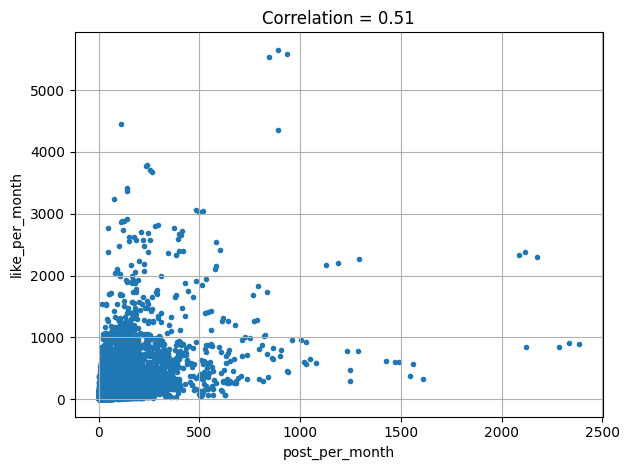

In [16]:
metric_pair_plot(churn_data, metric_1, metric_2s[0])
# before standarization

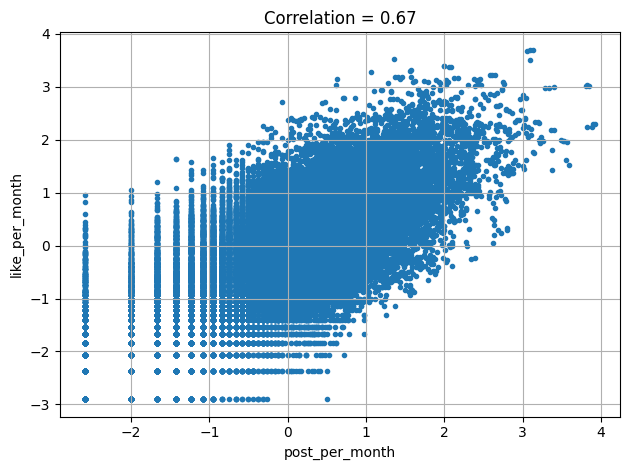

In [17]:
metric_pair_plot(scored, metric_1, metric_2s[0])

- the original observation only has 0.51 coorelation, and the plot shows no strong coorelation
  - several outliners also distort the v
- scored data does show there're some correlations between likes and posts
  - with coorelation at 0.67

- 6.1.3 Correlation matrices

In [18]:
import seaborn as sns

<AxesSubplot:>

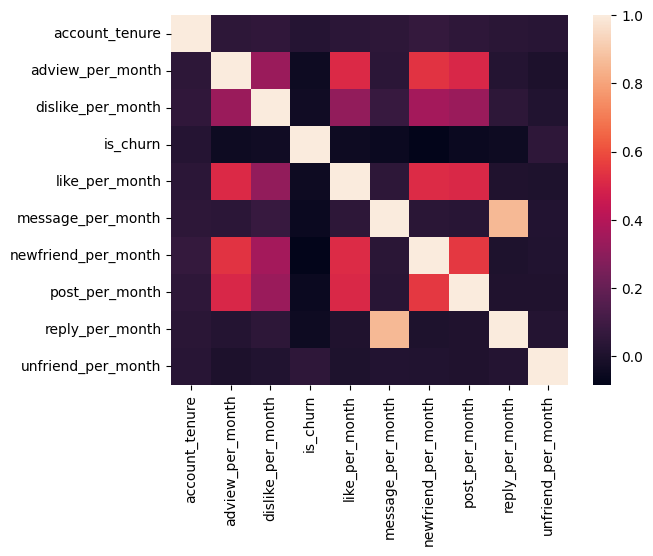

In [24]:
tmp = churn_data.drop(columns=["account_id"])
# tmp.reindex(columns=sorted(tmp.columns)).corr()
sns.heatmap(tmp.reindex(columns=sorted(tmp.columns)).corr())

<AxesSubplot:>

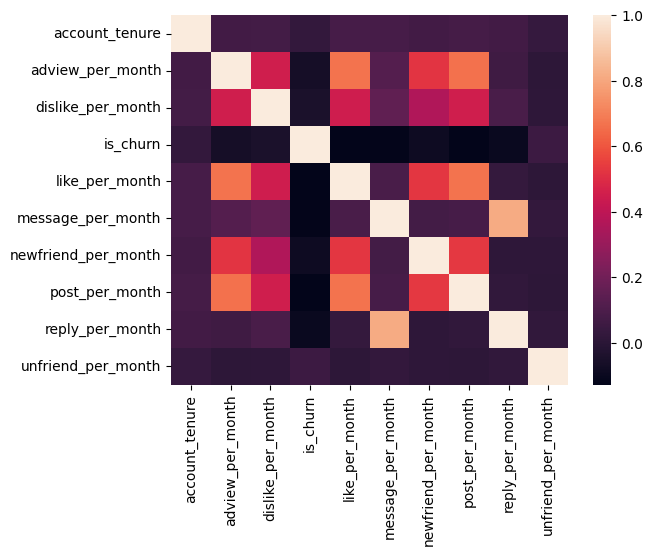

In [25]:
tmp = scored.drop(columns=["account_id"])
# tmp.reindex(columns=sorted(tmp.columns)).corr()
sns.heatmap(tmp.reindex(columns=sorted(tmp.columns)).corr())

### 6.3 Discovering groups of correlated metrics

> - Hierarchical clustering to find groups that are closer to each other
>- ...

--- 

- List 6.4 & List 6.5
- 6.3.2 Clustering correlations in Python

1. start with correlation matrix, find the "highest" correlation between any two metrics
   - first group contains the two metrics having the highest
2. create a loading matrix (weight matrix) (which will transform the original dataset)
   - resulting dataset having the two metrics in one group, others remain separated
   - i.e. the loading matrix has one fewer columns
3. use the loading matrix to transform the original dataset
4. repeat from step 1 with new pair of highest correlations

- `scipy.cluster.hierarch.linkage`
   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
   - Perform hierarchical/agglomerative clustering
- `scipy.cluster.hierarchy.fcluster`
   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
   - Form flat clusters from the hierarchical clustering defined by the given linkage matrix.
- `scipy.cluster.hierarchy.linkage`
   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html
   - Convert a vector-form distance vector to a square-form distance matrix, and vice-versa.

Resources

- https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

In [38]:
from collections import Counter
from scipy import cluster, spatial
from scipy import spatial

#### `find_correlation_clusters`

In [36]:
def find_correlation_clusters(corr, corr_thresh):
    
    dissimilarity = 1.0 - corr # broadcasted substraction
    # perform hierarchical clustering
    hierarchy = cluster.hierarchy.linkage(
        spatial.distance.squareform(dissimilarity), 
        method='single' # single: Nearest Point Algorithm
    )
    
    diss_thresh = 1.0 - corr_thresh
    # return the assgined clustrs for the groups
    labels = cluster.hierarchy.fcluster(
        hierarchy, diss_thresh, criterion='distance'
    )
    
    return labels

In [37]:
corr = scored.drop(columns=["account_id", "observation_date"]).corr()
corr_threshold = 0.5
find_correlation_clusters(corr, corr_threshold)

array([5, 2, 2, 2, 2, 3, 6, 1, 1, 4], dtype=int32)

In [67]:
dissimilarity = 1.0 - corr # broadcasted substraction
tmp = spatial.distance.squareform(dissimilarity)
display(tmp.shape)
tmp
# essentially the upper half of the "coorelation matrix" with 0 removed

(45,)

array([1.12363527, 1.08387946, 1.12747015, 1.0645889 , 1.04802937,
       0.94865586, 1.12048122, 1.09842071, 0.97735055, 0.47223598,
       0.33364346, 0.33392815, 0.55117994, 0.99513884, 0.91153994,
       0.9718675 , 0.91730273, 0.46691467, 0.47859298, 0.63478542,
       0.98692674, 0.92781908, 0.99047339, 0.9316508 , 0.33906513,
       0.55036139, 0.99138535, 0.91693736, 0.97885721, 0.9207497 ,
       0.54964922, 0.99512343, 0.88078285, 0.94105526, 0.93277774,
       0.98932806, 0.84835369, 0.90741681, 0.9275738 , 0.97737899,
       0.9796164 , 0.96579672, 0.18778264, 0.91851317, 0.93331093])

In [68]:
# np.delete(dissimilarity.values, 0.)
tmp = dissimilarity.values.flatten()
np.delete(dissimilarity.values.flatten(), np.argwhere(tmp==0)).shape
# remove 0 from the given dis similarity matrix
# but since it's duplicated along the diagnoal line, the number is doubled 

(90,)

In [71]:
tmp = cluster.hierarchy.linkage(
    spatial.distance.squareform(dissimilarity), 
    method='single' # single: Nearest Point Algorithm
)
# each row of the resulting array has the format [idx1, idx2, dist, sample_count].
display(tmp[0])
# merge the two clusters with indices 7 and 8, as they only had a distance of 0.18778264.
# This created a cluster with a total of 2 samples.

tmp
# we have 45 samples? doesn't make sense as 

array([7.        , 8.        , 0.18778264, 2.        ])

array([[ 7.        ,  8.        ,  0.18778264,  2.        ],
       [ 1.        ,  3.        ,  0.33364346,  2.        ],
       [ 4.        , 11.        ,  0.33392815,  3.        ],
       [ 2.        , 12.        ,  0.46691467,  4.        ],
       [ 5.        , 13.        ,  0.54964922,  5.        ],
       [10.        , 14.        ,  0.84835369,  7.        ],
       [ 9.        , 15.        ,  0.91730273,  8.        ],
       [ 0.        ,  6.        ,  0.94865586,  2.        ],
       [16.        , 17.        ,  0.96579672, 10.        ]])

In [73]:
hierarchy = cluster.hierarchy.linkage( 
    spatial.distance.squareform(dissimilarity),  
    method='single' # single: Nearest Point Algorithm
)
    
diss_thresh = 1.0 - corr_threshold
tmp = cluster.hierarchy.fcluster(
    hierarchy, diss_thresh, criterion='distance' 
)
tmp
# 10, the number of metrics in the scored data
# 5 of them are assigned to the same cluster
# each item in the array is an element, and the number represents the cluster it is assigned to

array([5, 2, 2, 2, 2, 3, 6, 1, 1, 4], dtype=int32)

#### `relabel_clusters`

In [36]:
def relabel_clusters(labels, metric_columns):
    
    # order the cluster by number of elements belonging to it
    cluster_count = Counter(labels)
    cluster_order = {cluster[0]: idx for idx, cluster in enumerate(cluster_count.most_common())}
    # this reduces the number of items in the dict
    
    relabeled_clusters = [cluster_order[l] for l in labels]
    relabled_count = Counter(relabeled_clusters)
    labeled_column_df = (
        pd.DataFrame({'group': relabeled_clusters, 'column': metric_columns})
        .sort_values(['group', 'column'], ascending=[True, True])
    )
    
    return labeled_column_df, relabled_count

In [84]:
labels = find_correlation_clusters(corr, corr_threshold)
display(labels)
metric_columns = scored.drop(columns=["account_id", "observation_date"]).columns.tolist()

cluster_count = Counter(labels)
# count of occurence of each cluster index, cluster 2 has 4 occurence
display(cluster_count.most_common())
cluster_count

array([5, 2, 2, 2, 2, 3, 6, 1, 1, 4], dtype=int32)

[(2, 4), (1, 2), (5, 1), (3, 1), (6, 1), (4, 1)]

Counter({5: 1, 2: 4, 3: 1, 6: 1, 1: 2, 4: 1})

In [89]:
# cluster_order = {cluster[0]: idx for idx, cluster in enumerate(cluster_count.most_common())}
cluster_order = {cluster: idx for idx, (cluster, _) in enumerate(cluster_count.most_common())}
cluster_order
# cluster 2 at index 0, after rating by number of items in the cluster

{2: 0, 1: 1, 5: 2, 3: 3, 6: 4, 4: 5}

In [90]:
display(labels)
relabeled_clusters = [cluster_order[label] for label in labels]
relabeled_clusters
# first item belongs to cluster 2, 
# but why would you need to do this? isn't the label already giving as the same ordering as the columns?

array([5, 2, 2, 2, 2, 3, 6, 1, 1, 4], dtype=int32)

[2, 0, 0, 0, 0, 3, 4, 1, 1, 5]

In [81]:
relabled_count = Counter(relabeled_clusters)
relabled_count

Counter({2: 1, 0: 4, 3: 1, 4: 1, 1: 2, 5: 1})

In [83]:
pd.DataFrame({'group': relabeled_clusters, 'column': metric_columns})\
   # .sort_values(['group', 'column'], ascending=[True, True])

,group,column
0,2,is_churn
1,0,like_per_month
2,0,newfriend_per_month
3,0,post_per_month
4,0,adview_per_month
5,3,dislike_per_month
6,4,unfriend_per_month
7,1,message_per_month
8,1,reply_per_month
9,5,account_tenure


#### `make_load_matrix`

In [118]:
def make_load_matrix(labeled_column_df, metric_columns, relabled_count, corr):
    load_mat = np.zeros((len(metric_columns), len(relabled_count)))
    
    for row in labeled_column_df.iterrows():
        orig_col = metric_columns.index(row[1][1])
        if relabled_count[row[1][0]]>1:
            load_mat[orig_col, row[1][0]] = 1.0/  (np.sqrt(corr) * float(relabled_count[row[1][0]])  )
        else:
            load_mat[orig_col, row[1][0]] = 1.0

    is_group = load_mat.astype(bool).sum(axis=0) > 1
    column_names=['metric_group_{}'.format(d + 1) if is_group[d]
                      else labeled_column_df.loc[labeled_column_df['group']==d,'column'].iloc[0]
                      for d in range(0, load_mat.shape[1])]
    loadmat_df = pd.DataFrame(load_mat, index=metric_columns, columns=column_names)   
    loadmat_df['name'] = loadmat_df.index
    sort_cols = list(loadmat_df.columns.values)
    sort_order = [False] * loadmat_df.shape[1]
    sort_order[-1] = True
    loadmat_df = loadmat_df.sort_values(sort_cols, ascending=sort_order)
    loadmat_df = loadmat_df.drop('name', axis=1)
    
    return loadmat_df

In [91]:
corr = scored.drop(columns=["account_id", "observation_date"]).corr()
corr_threshold = 0.5

In [92]:
labels = find_correlation_clusters(corr, corr_threshold)
metric_columns = scored.drop(columns=["account_id", "observation_date"]).columns.tolist()

labeled_column_df, relabled_count = relabel_clusters(labels, metric_columns)

In [100]:
make_load_matrix(labeled_column_df, metric_columns, relabled_count, corr)

ValueError: setting an array element with a sequence.

In [93]:
load_mat = np.zeros((len(metric_columns), len(relabled_count)))
load_mat

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [106]:
load_mat[orig_col, row[1][0]]

0.0

In [103]:
float(relabled_count[row[1][0]])

4.0

In [95]:
# iterate though each metric and its group
for row in labeled_column_df.iterrows():
    orig_col = metric_columns.index(row[1][1])
    if relabled_count[row[1][0]]>1:
        load_mat[orig_col, row[1][0]] = (1.0 / (np.sqrt(corr) * float(relabled_count[row[1][0]])))
    else:
        load_mat[orig_col, row[1][0]] = 1.0
load_mat

ValueError: setting an array element with a sequence.

#### `find_metric_groups`

In [122]:
def find_metric_groups(scored_data, group_corr_thresh=0.5):

    scored_metrics = scored_data.drop(columns=["account_id", "observation_date"])
    metrics = scored_metrics.columns.tolist()

    # 1. 
    labels = find_correlation_clusters(
        scored_metrics.corr(), group_corr_thresh
    )
    labeled_column_df, relabled_count = relabel_clusters(labels, metrics)
    loadmat_df = make_load_matrix(labeled_column_df, metrics, relabled_count, group_corr_thresh)
    
    return loadmat_df, labeled_column_df

In [123]:
scored.head()

,account_id,observation_date,is_churn,like_per_month,newfriend_per_month,post_per_month,adview_per_month,dislike_per_month,unfriend_per_month,message_per_month,reply_per_month,account_tenure
0,1,2020-02-23,False,-2.060782,-0.830069,-0.956225,-1.910692,-0.803795,1.310188,-0.510905,0.532077,-1.185010
1,1,2020-03-23,False,-2.060782,-0.714693,-0.956225,-1.578028,-1.074233,3.164898,-0.404155,0.231965,-0.238861
2,1,2020-04-23,False,-2.370355,-0.714693,-1.664403,-1.158921,-0.594028,1.310188,-0.404155,0.032935,0.707287
3,2,2020-03-08,True,0.322026,-0.022436,0.687066,1.482007,2.401324,-0.544521,-2.066550,-1.203553,-0.205070
4,4,2020-02-24,False,-0.142633,-0.368565,0.202450,0.483194,-0.422635,1.310188,0.728709,0.756234,-1.218801


In [126]:
result = find_metric_groups(scored)
result[0]

,metric_group_1,metric_group_2,is_churn,dislike_per_month,unfriend_per_month,account_tenure
adview_per_month,0.353553,0.000000,0.0,0.0,0.0,0.0
like_per_month,0.353553,0.000000,0.0,0.0,0.0,0.0
newfriend_per_month,0.353553,0.000000,0.0,0.0,0.0,0.0
post_per_month,0.353553,0.000000,0.0,0.0,0.0,0.0
message_per_month,0.000000,0.707107,0.0,0.0,0.0,0.0
reply_per_month,0.000000,0.707107,0.0,0.0,0.0,0.0
is_churn,0.000000,0.000000,1.0,0.0,0.0,0.0
dislike_per_month,0.000000,0.000000,0.0,1.0,0.0,0.0
unfriend_per_month,0.000000,0.000000,0.0,0.0,1.0,0.0
account_tenure,0.000000,0.000000,0.0,0.0,0.0,1.0


In [127]:
result[1]

,group,column
4,0,adview_per_month
1,0,like_per_month
2,0,newfriend_per_month
3,0,post_per_month
7,1,message_per_month
8,1,reply_per_month
0,2,is_churn
5,3,dislike_per_month
6,4,unfriend_per_month
9,5,account_tenure


### 6.2 Averaging groups of behavioural metrics

> - Averaging them (the metric cohorts) together is a way to handle this, as will be explained.
> - An information overload comes from looking at too many metrics. 
> - Remember that behavioral metrics usually do not measure something that is directly causal of churn or retention. 
>- It is more common that your behavioral metrics are only associated with churn.

--- 

- A matrix of weights, i.e. the loading matrix
- List 6.3
- Chapter 6.2.4


In [24]:
pprint(chap6["list3"])

{'name': 'apply_metric_groups',
 'params': {},
 'v1': {'data_set_path': 'socialnet7/socialnet7_dataset3_dumcat.csv'}}


In [ ]:
import pandas as pd
import numpy as np
import os

def apply_metric_groups(data_set_path):

    score_save_path=data_set_path.replace('.csv','_scores.csv')
    assert os.path.isfile(score_save_path),'You must run listing 5.3 or 7.5 to save metric scores first'
    score_data = pd.read_csv(score_save_path,index_col=[0,1])
    data_2group = score_data.drop('is_churn',axis=1)

    load_mat_path = data_set_path.replace('.csv', '_load_mat.csv')
    assert os.path.isfile(load_mat_path),'You must run listing 6.4 to save a loading matrix first'
    load_mat_df = pd.read_csv(load_mat_path, index_col=0)
    load_mat_ndarray = load_mat_df.to_numpy()

    # Make sure the data is in the same column order as the rows of the loading matrix
    ndarray_2group = data_2group[load_mat_df.index.values].to_numpy()
    grouped_ndarray = np.matmul(ndarray_2group, load_mat_ndarray)

    churn_data_grouped = pd.DataFrame(grouped_ndarray,columns=load_mat_df.columns.values, index=score_data.index)

    churn_data_grouped['is_churn'] = score_data['is_churn']

    save_path = data_set_path.replace('.csv', '_groupscore.csv')
    churn_data_grouped.to_csv(save_path,header=True)
    print('Saved grouped data  to ' + save